# Image classification with AffectNet dataset

**Image classification** is a core computer vision task: assigning one (single-label) or multiple (multi-label) predefined class labels to an input image. Technically, it maps an image tensor $x \in \mathbb{R}^{H \times W \times C}$ to a probability distribution over $K$ classes using a learned function $f_\theta(x)$.

**Top 5 Practical Use Cases**

1. **Medical Imaging** → Detecting diseases from X-rays, MRIs, histopathology slides.
2. **Retail / E-commerce** → Product categorization, visual search, recommendation.
3. **Autonomous Driving** → Road sign recognition, pedestrian vs. vehicle distinction.
4. **Agriculture** → Crop/plant disease classification, yield quality monitoring.
5. **Security / Surveillance** → Face ID, object/weapon detection, anomaly detection.

You are most likely to use image classification with

1. **Few-shot / zero-shot classification** (e.g. CLIP, ALIGN) → generalization to unseen categories where you can train models to correctly classify or tag images for *new categories* with little (few-shot) or no (zero-shot) labeled training data.

*Example*:

Social media platforms constantly face *new memes, visual trends, logos, or harmful content formats*. These categories may not exist in the training data.
A new hand-sign meme emerges. A zero-shot classifier like **CLIP** can associate the hand sign with a harmful or benign meaning based on text prompts (“offensive gesture”, “peace sign”), even if it has *never* seen that exact meme in training.

2. **Domain adaptation** → Transfer models trained on one domain (e.g., ImageNet or web images) to another domain with limited or no labeled data.

*Example*:

Social media images are *low-quality, compressed, filtered*, and full of overlays (text, stickers, emojis). These distributions differ heavily from curated training datasets.

A standard classifier may fail to recognize a cat when it’s hidden behind AR filters, emojis, or glitch effects. Domain adaptation can help models align to the “social media style” of imagery.

3. **Interpretability and robustness** → Understanding *why* a classifier makes a prediction and ensuring it works reliably under distribution shifts.

*Example*:

* Classifiers risk misclassifying due to **spurious correlations**.

If most “beach party” training images include *cans of Coca-Cola*, the model may overfit to “red cans” rather than recognizing the *scene* itself. On TikTok, it might then mislabel a protest photo (with someone holding a Coke) as “beach party.”

* **Interpretability tools** (saliency maps, attention rollout, counterfactual explanations) are essential to detect when models are keying on irrelevant artifacts (logos, watermarks).
  
* **Robustness angle**: New visual styles (e.g., generative AI memes, deepfakes, filters) cause **distribution shifts** → performance collapse unless explicitly probed.


---

## Top Transformer-Based Models for Image Classification

1. **Vision Transformer (ViT, 2020)**

   * First pure Transformer for images (Dosovitskiy et al., ICLR 2021).
   * Patch embeddings → Transformer encoder → classification token.

2. **DeiT (Data-Efficient Image Transformer, 2020)**

   * Distilled training strategy for ViTs without massive datasets (Touvron et al., ICML 2021).

3. **Swin Transformer (2021)**

   * Hierarchical, shifted-window attention → scalable to detection/segmentation (Liu et al., ICCV 2021).

4. **ConvNeXt (2022)**

   * Not Transformer but CNN redesigned with ViT-style training tricks (Liu et al., CVPR 2022) — competitive baseline.

5. **CLIP (2021)**

   * Contrastive vision–language pretraining (Radford et al., ICML 2021).
   * Enables zero-shot classification by aligning image and text embeddings.

6. **BEiT / BEiTv2 (2021–2022)**

   * BERT-style masked image modeling for pretraining vision Transformers.

7. **EVA / EVA-CLIP (2023)**

   * Large-scale vision–language pretraining (Fang et al., CVPR 2023). Stronger CLIP variants with >4B parameters.

8. **SAM (Segment Anything, 2023)** & derivatives

   * Technically segmentation, but used in classification pipelines for fine-grained tasks.

---

## 🚧 Current Challenges in Cutting-Edge Research

1. **Data & compute scaling limits**

   * *Dosovitskiy et al. (ViT, ICLR 2021)* showed ViTs need massive datasets (JFT-300M) to outperform CNNs.
   * Research now focuses on **efficient training** (DeiT, DINOv2, MAE) to reduce data dependency.

2. **Robustness to distribution shift**

   * *Taori et al., NeurIPS 2020 (“Measuring Robustness to Natural Distribution Shifts in Image Classification”)* found that models trained on ImageNet degrade sharply on ImageNet-V2, ObjectNet, etc.
   * Still a major bottleneck in deploying classifiers beyond benchmark datasets.

3. **Adversarial and spurious correlations**

   * *Geirhos et al., Nature Machine Intelligence 2020 (“Shortcut Learning in Deep Neural Networks”)*: models often latch on to textures, backgrounds, or dataset artifacts rather than semantic content.
   * Current work explores **causal and invariant learning**.

4. **Zero-shot / cross-modal alignment quality**

   * *Radford et al., CLIP (ICML 2021)* showed impressive zero-shot performance, but follow-ups (*Zhai et al., ALIGN 2021; Fang et al., EVA-CLIP 2023*) highlight biases from noisy web-scale data.
   * Research problem: scaling data without amplifying spurious correlations or social biases.

5. **Interpretability & trustworthiness**

   * *Chefer et al., CVPR 2021 (“Transformer Interpretability Beyond Attention Visualization”)*: attention ≠ explanation. New methods needed for reliable interpretation of classification decisions.

---

## AffectNet Dataset

* **AffectNet** (Mollahosseini et al., 2017, IEEE Transactions on Affective Computing) is one of the **largest facial expression datasets** for affective computing.
* **Scale**: >1 million facial images crawled from the web using \~1250 emotion-related keywords in 6 languages. About 440,000 images were manually annotated.
* **Annotations**:
  * **Discrete emotion labels**: 8 categories (happy, sad, angry, surprise, fear, disgust, contempt, neutral).
  * **Continuous affect values**: Valence (positive ↔ negative) and Arousal (calm ↔ excited) scores in $[-1,1]$.
* **Purpose**: Benchmark for training and evaluating models in **facial expression recognition (FER)** and **affective state analysis**.

AffectNet is a popular dataset to demonstrate different computer vision tasks. Apart from image classification it is also used for object detection with **YOLOv (YOLOv3, v5, v8, etc.)** approach.

In this case modeling is split into two stages:

  * Step 1: **Face detection** → Use YOLO to detect bounding boxes of faces in social/“in-the-wild” images.
  * Step 2: Crop/align detected faces, then feed them into an emotion classifier.

* **Reason**: AffectNet images are scraped “in the wild” (unconstrained backgrounds, lighting, occlusion). Raw frames often contain **multiple people or clutter**, so you need reliable face localization first. YOLO is fast and robust for this preprocessing stage.

For **Step 2** we are going to use a ViT model, **ViT** (Dosovitskiy et al., 2020) which is a **pure Transformer architecture for image classification**, treating images as sequences of patch tokens.

* In the context of AffectNet:

  * Once faces are localized (e.g. by YOLO), **ViT is used as the classifier** to predict discrete emotions or regress valence/arousal.
  
You can read more about this approach in recent papers (e.g., “Transformer-Based Facial Expression Recognition” in *Pattern Recognition 2022*) that show that ViTs outperform earlier non-transformer models (ResNets on AffectNet) in many FER benchmarks.

---

**Steps**

1. **Image** → YOLO detects **face bounding box**.
2. **Crop & Normalize face** → resize to ViT input.
3. **ViT classifier** → outputs emotion category or valence–arousal.

---

* **YOLOv + AffectNet** = strong preprocessing for noisy, real-world facial data.
* **ViT + AffectNet** = improved representation learning, capturing subtle emotional signals.

* Together → robust facial emotion recognition pipeline usable for **HCI, social robotics, affective computing, and social media sentiment analysis**.


## AffectNet on Kaggle

We are going to use the version of the dataset available on [Kaggle](https://www.kaggle.com/datasets/fatihkgg/affectnet-yolo-format)

The dataset is already in "YOLO format" which means that
- The dataset already has facial bounding boxes applied using YOLO (**Step 1**

- The images are cropped to focus on faces (**Step 2**)

We are getting clean, face-centered images ready for emotion classification

To get the data from Kaggle we use the library to download it

**What Happens Behind the Scenes**
- **Authentication**: Uses your Kaggle API token (usually stored at ~/.kaggle/kaggle.json)

- **Download**: Fetches the dataset files from Kaggle's servers

- **Storage**: Saves files to a local cache directory

- **Return**: Provides the path to access the downloaded files

In [ ]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")

print("Path to dataset files:", path)

100%|██████████| 258M/258M [00:09<00:00, 29.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2


Let's explore files:

In [ ]:
!ls -lh /root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2       # list top-level files/folders


total 4.0K
drwxr-xr-x 5 root root 4.0K Sep 19 01:40 YOLO_format


That means the dataset was unpacked into a folder named `YOLO_format`. To see what’s inside and how it’s structured, drill down a bit further:

In [ ]:
!ls -lh /root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format


total 16K
-rw-r--r-- 1 root root  500 Sep 19 01:40 data.yaml
drwxr-xr-x 4 root root 4.0K Sep 19 01:40 test
drwxr-xr-x 4 root root 4.0K Sep 19 01:40 train
drwxr-xr-x 4 root root 4.0K Sep 19 01:40 valid


In [ ]:
!ls -lh /root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format/train

total 1.1M
drwxr-xr-x 2 root root 540K Sep 19 01:40 images
drwxr-xr-x 2 root root 540K Sep 19 01:40 labels


In [ ]:
# List training set structure
!ls -lh /root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format/train

# Peek at first few labels/images
!ls -lh /root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format/train/images | head
!ls -lh /root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format/train/labels | head


total 1.1M
drwxr-xr-x 2 root root 540K Sep 19 01:40 images
drwxr-xr-x 2 root root 540K Sep 19 01:40 labels
total 201M
-rw-r--r-- 1 root root  21K Sep 19 01:40 ffhq_0.png
-rw-r--r-- 1 root root  21K Sep 19 01:40 ffhq_1000.png
-rw-r--r-- 1 root root  21K Sep 19 01:40 ffhq_1001.png
-rw-r--r-- 1 root root  20K Sep 19 01:40 ffhq_1003.png
-rw-r--r-- 1 root root  19K Sep 19 01:40 ffhq_1004.png
-rw-r--r-- 1 root root  19K Sep 19 01:40 ffhq_1005.png
-rw-r--r-- 1 root root  21K Sep 19 01:40 ffhq_1007.png
-rw-r--r-- 1 root root  19K Sep 19 01:40 ffhq_1008.png
-rw-r--r-- 1 root root  23K Sep 19 01:40 ffhq_1009.png
total 67M
-rw-r--r-- 1 root root 25 Sep 19 01:40 ffhq_0.txt
-rw-r--r-- 1 root root 25 Sep 19 01:40 ffhq_1000.txt
-rw-r--r-- 1 root root 25 Sep 19 01:40 ffhq_1001.txt
-rw-r--r-- 1 root root 25 Sep 19 01:40 ffhq_1003.txt
-rw-r--r-- 1 root root 25 Sep 19 01:40 ffhq_1004.txt
-rw-r--r-- 1 root root 25 Sep 19 01:40 ffhq_1005.txt
-rw-r--r-- 1 root root 25 Sep 19 01:40 ffhq_1007.txt
-rw-r--r-- 1

### Display images and corresponding labels

In the YOLO version of AffectNet, each image has a corresponding .txt file in the labels/ folder with the same basename. That text file contains one line per bounding box, with the first value being the class ID. You can display the image and overlay its label like this:

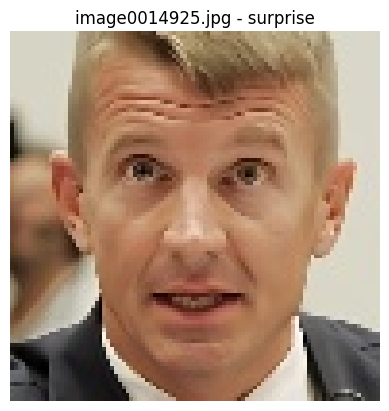

In [ ]:
import os, random
from PIL import Image
import matplotlib.pyplot as plt

# Paths (adjust if needed)
img_dir = "/root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format/train/images"
lbl_dir = "/root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format/train/labels"

# AffectNet YOLO classes (from data.yaml or docs)
id2label = {
    0: "anger",
    1: "contempt",
    2: "disgust",
    3: "fear",
    4: "happy",
    5: "neutral",
    6: "sad",
    7: "surprise"
}

# Pick a random image
random_file = random.choice([f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".png",".jpeg"))])
img_path = os.path.join(img_dir, random_file)
label_path = os.path.join(lbl_dir, os.path.splitext(random_file)[0] + ".txt")

# Read label (take the first box if multiple are present)
cls_id = None
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        line = f.readline().strip()
        if line:
            cls_id = int(line.split()[0])

# Load and show image with label
img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")
title = f"{random_file} - {id2label.get(cls_id, 'no_label')}" if cls_id is not None else random_file
plt.title(title)
plt.show()


We need to convert the data into a format that we can process with Hugging Face infrastructure.

- We set out folder structure with

**BASE**: Source directory with YOLO-format dataset

**OUT**: Target directory for ImageFolder format

- We create a column with labels: either using `yaml` file or providing labels manually

- We need to match image files with corresponding text labels

- As we combine files we keep track of how many examples per class for each split.

- Finally, we load the converted dataset using Hugging Face's `ImageFolder` format, which automatically:

- Uses subfolder names as class labels

- Organizes data by splits (train/val/test)

- Provides standardized interface to be used later.

>*Hint*: `data.yaml` file is the standard configuration file that contains:



```
# data.yaml example for AffectNet emotion dataset
train: ../train/images
test: ../test/images

nc: 8  # number of classes
names:
  0: anger
  1: contempt
  2: disgust
  3: fear
  4: happy
  5: neutral
  6: sad
  7: surprise
```

#### ImageFolder at Hugging Face

The `ImageFolder` is a [dataset builder](https://huggingface.co/docs/datasets/en/image_dataset) designed to quickly load an image dataset with several thousand images without requiring you to write any code.

> `ImageFolder` automatically infers the class labels of your dataset based on the directory name. Store your dataset in a directory structure like:



```
folder/train/dog/golden_retriever.png
folder/train/dog/german_shepherd.png
folder/train/dog/chihuahua.png

folder/train/cat/maine_coon.png
folder/train/cat/bengal.png
folder/train/cat/birman.png
```

If the dataset follows the ImageFolder structure, then you can load it directly with load_dataset()

If there is additional information you’d like to include about your dataset, like text captions or bounding boxes, add it as a `metadata.csv` file in your folder. This lets you quickly create datasets for different computer vision tasks like text captioning or object detection. You can also use a JSONL file metadata.jsonl or a Parquet file metadata.parquet.


In [ ]:
import os, shutil, pathlib, yaml, collections
from tqdm import tqdm
from datasets import load_dataset

# --- 1) Paths ---
BASE = "/root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format"
OUT  = "/content/affectnet_imagefolder"  # new imagefolder root we will create

# --- 2) Read class names from data.yaml if present ---
yaml_path = os.path.join(BASE, "data.yaml")
if os.path.exists(yaml_path):
    with open(yaml_path, "r") as f:
        data_cfg = yaml.safe_load(f)
    # names can be list or dict; normalize to list
    names = data_cfg.get("names", [])
    if isinstance(names, dict):
        # dict like {0: 'anger', 1:'contempt', ...} -> list in index order
        names = [names[k] for k in sorted(names, key=lambda x: int(x))]
else:
    # Fallback labels if data.yaml is missing; reorder if your dataset differs
    names = ["anger","contempt","disgust","fear","happy","neutral","sad","surprise"]

id2label = {i: n for i, n in enumerate(names)}
label2id = {n: i for i, n in id2label.items()}

print("Classes:", id2label)

# --- 3) Utility to ensure a directory exists ---
def ensure_dir(p):
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)

# --- 4) Convert each split by symlinking images into class folders ---
splits = [d for d in ["train","val","test"] if os.path.isdir(os.path.join(BASE, d))]
if not splits:
    raise RuntimeError(f"No split folders found under {BASE}. Expected train/val[/test].")

ensure_dir(OUT)
per_split_counts = {}

for split in splits:
    img_root = os.path.join(BASE, split, "images")
    lbl_root = os.path.join(BASE, split, "labels")
    if not os.path.isdir(img_root) or not os.path.isdir(lbl_root):
        print(f"Skipping {split}: missing images/labels dirs")
        continue

    print(f"Processing split: {split}")
    # prepare class folders for this split
    for cname in names:
        ensure_dir(os.path.join(OUT, split, cname))

    counts = collections.Counter()
    # iterate over images by matching label basenames
    # consider common extensions
    exts = (".jpg",".jpeg",".png",".bmp",".webp")
    img_files = [f for f in os.listdir(img_root) if f.lower().endswith(exts)]

    for fname in tqdm(img_files):
        stem = os.path.splitext(fname)[0]
        img_path = os.path.join(img_root, fname)
        lbl_path = os.path.join(lbl_root, stem + ".txt")
        if not os.path.exists(lbl_path):
            # no label -> skip (or default to a class)
            continue

        # Parse YOLO label: class x y w h [optional extras]. Use FIRST line.
        # If multiple boxes/classes exist, this picks the first one for classification.
        try:
            with open(lbl_path, "r") as f:
                first_line = f.readline().strip()
            if not first_line:
                continue
            cls_id = int(float(first_line.split()[0]))
        except Exception:
            continue

        # guard bad ids
        if cls_id not in id2label:
            continue
        cname = id2label[cls_id]

        # destination symlink path
        dest_dir = os.path.join(OUT, split, cname)
        dest_path = os.path.join(dest_dir, fname)

        # create symlink (fast, no extra storage). If filesystem disallows symlink, fall back to hardlink/copy.
        try:
            if not os.path.exists(dest_path):
                os.symlink(img_path, dest_path)
        except OSError:
            # Try hardlink
            try:
                if not os.path.exists(dest_path):
                    os.link(img_path, dest_path)
            except OSError:
                # Fall back to copy (slower, uses space)
                shutil.copy2(img_path, dest_path)

        counts[cname] += 1

    per_split_counts[split] = counts

print("\nPer-split class counts:")
for split, cnt in per_split_counts.items():
    print(split, dict(cnt))

# --- 5) Load with Hugging Face `imagefolder` ---
dataset = load_dataset(
    "imagefolder",
    data_dir=OUT,
    split={s: s for s in splits}  # e.g., {"train":"train","val":"val","test":"test"}
)

# The label names come from subfolder names; check them:
print("\nHF `imagefolder` detected labels:", dataset[splits[0]].features["label"].names)

# Quick sanity check: show 1 example and its label
sample = dataset[splits[0]][0]
print("Sample keys:", sample.keys())
print("Label id:", sample["label"])
print("Label name:", dataset[splits[0]].features["label"].names[sample["label"]])


Classes: {0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
Processing split: train


100%|██████████| 17101/17101 [00:03<00:00, 5328.74it/s]


Processing split: test


100%|██████████| 2755/2755 [00:00<00:00, 5449.38it/s]



Per-split class counts:
train {'Disgust': 2242, 'Contempt': 1996, 'Surprise': 2819, 'Neutral': 1616, 'Anger': 2339, 'Sad': 1914, 'Fear': 2021, 'Happy': 2154}
test {'Surprise': 468, 'Sad': 278, 'Disgust': 327, 'Anger': 383, 'Happy': 399, 'Contempt': 332, 'Neutral': 250, 'Fear': 318}


Resolving data files:   0%|          | 0/17101 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2755 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]


HF `imagefolder` detected labels: ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Sample keys: dict_keys(['image', 'label'])
Label id: 0
Label name: Anger


In [ ]:
import os, shutil, pathlib, yaml, collections
from tqdm import tqdm
from datasets import load_dataset

# --- 1) Paths ---
BASE = "/root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format"
OUT  = "/content/affectnet_imagefolder"

# --- 2) Read class names from data.yaml with better handling ---
yaml_path = os.path.join(BASE, "data.yaml")
if os.path.exists(yaml_path):
    with open(yaml_path, "r") as f:
        data_cfg = yaml.safe_load(f)

    names = data_cfg.get("names", [])

    # Handle different YAML formats
    if isinstance(names, dict):
        # Convert dict to list in correct order
        names = [names[str(k)] for k in sorted(map(int, names.keys()))]
    elif isinstance(names, list):
        # Ensure proper capitalization
        names = [name.strip().capitalize() for name in names]
    else:
        names = []
else:
    # Use capitalized fallback to match what Hugging Face expects
    names = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Create mappings with consistent capitalization
id2label = {i: n for i, n in enumerate(names)}
label2id = {n: i for i, n in id2label.items()}

print("Classes:", id2label)

# --- 3) Utility to ensure a directory exists ---
def ensure_dir(p):
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)

# --- 4) Convert each split ---
splits = [d for d in ["train","val","test"] if os.path.isdir(os.path.join(BASE, d))]
if not splits:
    raise RuntimeError(f"No split folders found under {BASE}. Expected train/val[/test].")

ensure_dir(OUT)
per_split_counts = {}

for split in splits:
    img_root = os.path.join(BASE, split, "images")
    lbl_root = os.path.join(BASE, split, "labels")

    if not os.path.isdir(img_root):
        print(f"Skipping {split}: missing images directory")
        continue
    if not os.path.isdir(lbl_root):
        print(f"Skipping {split}: missing labels directory")
        continue

    print(f"Processing split: {split}")

    # Create class folders with exact capitalization
    for cname in names:
        ensure_dir(os.path.join(OUT, split, cname))

    counts = collections.Counter()
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp", ".JPG", ".JPEG", ".PNG")
    img_files = [f for f in os.listdir(img_root) if f.lower().endswith(exts)]

    for fname in tqdm(img_files):
        stem = os.path.splitext(fname)[0]
        img_path = os.path.join(img_root, fname)
        lbl_path = os.path.join(lbl_root, stem + ".txt")

        if not os.path.exists(lbl_path):
            # Try alternative extensions
            for ext in ['.txt', '.TXT']:
                alt_path = os.path.join(lbl_root, stem + ext)
                if os.path.exists(alt_path):
                    lbl_path = alt_path
                    break
            else:
                continue  # No label file found

        try:
            with open(lbl_path, "r") as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]

            if not lines:
                continue

            # Get the most frequent class in the image (better for classification)
            class_counts = collections.Counter()
            for line in lines:
                try:
                    cls_id = int(float(line.split()[0]))
                    if cls_id in id2label:
                        class_counts[cls_id] += 1
                except (ValueError, IndexError):
                    continue

            if not class_counts:
                continue

            # Use the most frequent class
            cls_id = class_counts.most_common(1)[0][0]
            cname = id2label[cls_id]

        except Exception as e:
            print(f"Error processing {lbl_path}: {e}")
            continue

        dest_dir = os.path.join(OUT, split, cname)
        dest_path = os.path.join(dest_dir, fname)

        try:
            if not os.path.exists(dest_path):
                os.symlink(img_path, dest_path)
        except OSError:
            try:
                if not os.path.exists(dest_path):
                    os.link(img_path, dest_path)
            except OSError:
                try:
                    shutil.copy2(img_path, dest_path)
                except Exception as e:
                    print(f"Failed to copy {img_path}: {e}")
                    continue

        counts[cname] += 1

    per_split_counts[split] = counts

print("\nPer-split class counts:")
for split, cnt in per_split_counts.items():
    print(split, dict(cnt))

# --- 5) Debug: Check what was actually created ---
print("\nChecking created directory structure:")
for split in splits:
    split_path = os.path.join(OUT, split)
    if os.path.exists(split_path):
        print(f"\n{split} directory contains:")
        for class_name in names:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                print(f"  {class_name}: {num_files} files")
            else:
                print(f"  {class_name}: MISSING")

# --- 6) Load with Hugging Face ---
try:
    dataset = load_dataset(
        "imagefolder",
        data_dir=OUT,
        split={s: s for s in splits}
    )

    print("\nHF `imagefolder` detected labels:", dataset[splits[0]].features["label"].names)

    # Verify consistency
    expected_names = names
    detected_names = dataset[splits[0]].features["label"].names

    if expected_names != detected_names:
        print(f"WARNING: Name mismatch! Expected: {expected_names}, Got: {detected_names}")

    # Quick sanity check
    sample = dataset[splits[0]][0]
    print("Sample keys:", sample.keys())
    print("Label id:", sample["label"])
    print("Label name:", dataset[splits[0]].features["label"].names[sample["label"]])

except Exception as e:
    print(f"Error loading dataset: {e}")
    # Try to diagnose
    if os.path.exists(OUT):
        print("Contents of output directory:")
        for root, dirs, files in os.walk(OUT):
            level = root.replace(OUT, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f'{indent}{os.path.basename(root)}/')

Classes: {0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
Processing split: train


100%|██████████| 17101/17101 [00:12<00:00, 1413.72it/s]


Processing split: test


100%|██████████| 2755/2755 [00:02<00:00, 1340.32it/s]



Per-split class counts:
train {'Disgust': 2242, 'Contempt': 1996, 'Surprise': 2819, 'Neutral': 1616, 'Anger': 2339, 'Sad': 1914, 'Fear': 2021, 'Happy': 2154}
test {'Surprise': 468, 'Sad': 278, 'Disgust': 327, 'Anger': 383, 'Happy': 399, 'Contempt': 332, 'Neutral': 250, 'Fear': 318}

Checking created directory structure:

train directory contains:
  Anger: 2339 files
  Contempt: 1996 files
  Disgust: 2242 files
  Fear: 2021 files
  Happy: 2154 files
  Neutral: 1616 files
  Sad: 1914 files
  Surprise: 2819 files

test directory contains:
  Anger: 383 files
  Contempt: 332 files
  Disgust: 327 files
  Fear: 318 files
  Happy: 399 files
  Neutral: 250 files
  Sad: 278 files
  Surprise: 468 files


Resolving data files:   0%|          | 0/17101 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2755 [00:00<?, ?it/s]


HF `imagefolder` detected labels: ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Sample keys: dict_keys(['image', 'label'])
Label id: 0
Label name: Anger


In [ ]:
data_train=dataset["train"]
print(data_train.features)
data_train[10]

{'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])}


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=96x96>,
 'label': 0}

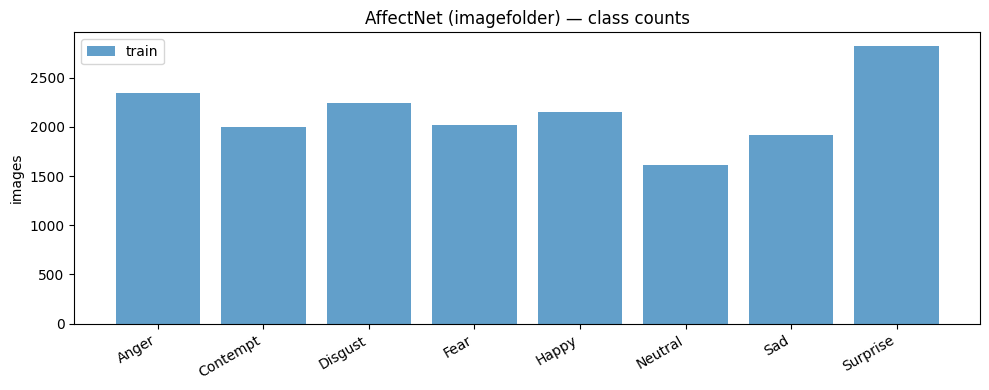

In [ ]:
# --- SANITY CHART: per-class counts in train vs validation ---
import matplotlib.pyplot as plt
import collections

label_names = dataset["train"].features["label"].names  # comes from imagefolder subdirs

def class_counts(ds):
    cnt = collections.Counter(int(x) for x in ds["label"])
    return [cnt.get(i, 0) for i in range(len(label_names))]

train_counts = class_counts(dataset["train"])

x = range(len(label_names))
plt.figure(figsize=(10,4))
plt.bar(x, train_counts, alpha=0.7, label="train")
plt.xticks(x, label_names, rotation=30, ha="right")
plt.ylabel("images")
plt.title("AffectNet (imagefolder) — class counts")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.0 MB/s eta 0:00:00


In [ ]:
# 2) baseline eval (no fine-tuning) on test
model_ckpt = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(model_ckpt)

def preprocess(ex):
    enc = processor(ex["image"], return_tensors="pt")
    # Convert to numpy arrays instead of tensors to avoid serialization issues
    ex["pixel_values"] = enc["pixel_values"][0].numpy()
    ex["labels"] = ex["label"]
    return ex

proc_test = dataset["test"].map(preprocess, remove_columns=["image"])

def collate_fn(batch):
    return {
        "pixel_values": torch.tensor([b["pixel_values"] for b in batch]),
        "labels": torch.tensor([b["labels"] for b in batch])
    }

id2label = {i: n for i, n in enumerate(label_names)}
label2id = {n: i for i, n in id2label.items()}

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

acc = evaluate.load("accuracy")
def compute_metrics(p):
    logits, labels = p
    preds = logits.argmax(axis=1)
    return acc.compute(predictions=preds, references=labels)

args = TrainingArguments(
    output_dir="./baseline_eval",
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    report_to="none",  # This disables all logging integrations
)



Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2755 [00:00<?, ? examples/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    output_dir="./baseline_eval",
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    report_to="none",  # This disables all logging integrations
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=proc_test,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

# Evaluate instead of train
baseline_results = trainer.evaluate()
print(f"Baseline (no fine-tuning) accuracy on TEST: {baseline_results['eval_accuracy']:.4f}")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maria_pro (maria_0) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Baseline (no fine-tuning) accuracy on TEST: 0.1256


### Interpreting the Results

- **Performance Level**
12.56% accuracy is almost exactly random chance for 8 classes (1/8 = 12.5%)

This means the pre-trained ViT model is performing no better than random guessing on your emotion recognition task

**Key Implications**
- **Complete domain mismatch**: The model's ImageNet knowledge doesn't transfer to facial emotions

- **Strong need for fine-tuning**: The model needs to learn emotion-specific features

**Save the metrics**

In [ ]:
import json

with open("baseline_results.json", "w") as f:
    json.dump(baseline_results, f)

# Later: load without rerunning evaluation
with open("baseline_results.json", "r") as f:
    baseline_results = json.load(f)

print(f"Baseline TEST accuracy (cached): {baseline_results['eval_accuracy']:.4f}")


Baseline TEST accuracy (cached): 0.1256


Save model predictions

In [ ]:
pred = trainer.predict(proc_test)

# Save
import numpy as np
np.save("baseline_logits.npy", pred.predictions)
np.save("baseline_labels.npy", pred.label_ids)




/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# Later: load
logits = np.load("baseline_logits.npy")
labels = np.load("baseline_labels.npy")

We can also visualise the results

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# Evaluate and get predictions
baseline_results = trainer.evaluate()
print(f"Baseline accuracy: {baseline_results['eval_accuracy']:.4f}")

# Get predictions for visualization
predictions = trainer.predict(proc_test)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# 1. Confusion Matrix
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Baseline Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 2. Classification Report
def print_classification_report(labels, preds, class_names):
    report = classification_report(labels, preds, target_names=class_names)
    print("Classification Report:")
    print(report)

# 3. Accuracy per Class
def plot_accuracy_per_class(labels, preds, class_names):
    class_accuracies = []
    for i, class_name in enumerate(class_names):
        mask = labels == i
        if np.sum(mask) > 0:
            accuracy = np.mean(preds[mask] == labels[mask])
            class_accuracies.append(accuracy)
        else:
            class_accuracies.append(0)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(class_names)), class_accuracies)
    plt.title('Accuracy per Emotion Class - Baseline Model')
    plt.xlabel('Emotion Class')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# 4. Distribution of Predictions vs Actual
def plot_prediction_distribution(labels, preds, class_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Actual distribution
    actual_counts = np.bincount(labels, minlength=len(class_names))
    ax1.bar(range(len(class_names)), actual_counts)
    ax1.set_title('Actual Label Distribution')
    ax1.set_xticks(range(len(class_names)))
    ax1.set_xticklabels(class_names, rotation=45)

    # Predicted distribution
    pred_counts = np.bincount(preds, minlength=len(class_names))
    ax2.bar(range(len(class_names)), pred_counts)
    ax2.set_title('Predicted Label Distribution')
    ax2.set_xticks(range(len(class_names)))
    ax2.set_xticklabels(class_names, rotation=45)

    plt.tight_layout()
    plt.show()

# Generate all visualizations
class_names = list(label_names.values())

print("="*50)
print("BASELINE MODEL PERFORMANCE VISUALIZATION")
print("="*50)

plot_confusion_matrix(labels, preds, class_names)
print_classification_report(labels, preds, class_names)
plot_accuracy_per_class(labels, preds, class_names)
plot_prediction_distribution(labels, preds, class_names)

# Print overall results
print(f"\nOverall Baseline Results:")
print(f"Accuracy: {baseline_results['eval_accuracy']:.4f}")
print(f"Loss: {baseline_results['eval_loss']:.4f}")

We can also add additional metrics for our model evaluation:

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def compute_detailed_metrics(p):
    logits, labels = p
    preds = logits.argmax(axis=1)

    accuracy = acc.compute(predictions=preds, references=labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Update trainer with detailed metrics
trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=proc_test,
    data_collator=collate_fn,
    compute_metrics=compute_detailed_metrics,
)



>### Fune tuning







In [ ]:
# ---- Quick Fine‑Tuning of ViT (head only) ----
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch

num_labels = len(label_names)
id2label = {i: n for i, n in enumerate(label_names)}
label2id = {n: i for i, n in enumerate(label_names)}

finetune_model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# freeze backbone
for param in finetune_model.vit.parameters():
    param.requires_grad = False

def preprocess_train(ex):
    enc = processor(ex["image"], return_tensors="pt")
    ex["pixel_values"] = enc["pixel_values"][0].numpy()
    ex["labels"] = ex["label"]
    return ex

train_subset = dataset["train"].shuffle(seed=42).select(range(min(2000, len(dataset["train"]))))
val_subset   = dataset["test"].shuffle(seed=42).select(range(min(500, len(dataset["test"]))))

proc_train = train_subset.map(preprocess_train, remove_columns=["image"])
proc_val   = val_subset.map(preprocess_train, remove_columns=["image"])

def collate_fn_ft(batch):
    return {
        "pixel_values": torch.tensor([b["pixel_values"] for b in batch]),
        "labels": torch.tensor([b["labels"] for b in batch]),
    }

training_args = TrainingArguments(
    output_dir="./finetuned_vit_head",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    remove_unused_columns=False,
    save_strategy="no",
    report_to="none",
)

def compute_metrics_ft(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return acc.compute(predictions=preds, references=labels)

trainer_ft = Trainer(
    model=finetune_model,
    args=training_args,
    train_dataset=proc_train,
    eval_dataset=proc_val,
    data_collator=collate_fn_ft,
    compute_metrics=compute_metrics_ft,
)

trainer_ft.train()
ft_results = trainer_ft.evaluate()
print(f"Fine-tuned head-only accuracy: {ft_results['eval_accuracy']:.4f}")


### Alternative models

Our biggest problem is the proper selection of the model to start and a strategy to improve its results.



In [ ]:
from huggingface_hub import HfApi, ModelFilter
import pandas as pd

# Search for models suitable for emotion recognition
api = HfApi()

# Search for models with "emotion" or "facial expression" in their name/description
emotion_models = api.list_models(
    filter=ModelFilter(
        task="image-classification",
        library="transformers",
        search="emotion facial expression affect"
    ),
    sort="downloads",
    direction=-1,
    limit=20
)

# Create a list of model info
model_list = []
for model in emotion_models:
    model_list.append({
        'Model ID': model.modelId,
        'Downloads': model.downloads,
        'Likes': model.likes,
        'Last Modified': model.lastModified,
        'Tags': model.tags
    })

# Convert to DataFrame for better display
df = pd.DataFrame(model_list)
print("Top Emotion Recognition Models on Hugging Face Hub:")
print(df[['Model ID', 'Downloads', 'Likes']].head(10))

In [ ]:
# Transformers installation
! pip install transformers datasets evaluate accelerate

In [2]:
from datasets import load_dataset

ds = load_dataset("sxdave/emotion_detection", split="train")

README.md:   0%|          | 0.00/116 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/157 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

train/happy/im10_png.rf.16ea8974e8fe08bf(…):   0%|          | 0.00/6.46k [00:00<?, ?B/s]

train/happy/im16_png.rf.9ffc1b74cf8ea8bc(…):   0%|          | 0.00/5.88k [00:00<?, ?B/s]

train/happy/im0_png.rf.01b188d72111febe2(…):   0%|          | 0.00/7.03k [00:00<?, ?B/s]

train/happy/im13_png.rf.adb60066d7a0b90c(…):   0%|          | 0.00/7.98k [00:00<?, ?B/s]

train/happy/im22_png.rf.e8ff001f5571c48f(…):   0%|          | 0.00/6.27k [00:00<?, ?B/s]

train/happy/im1_png.rf.f7a738615b18f2845(…):   0%|          | 0.00/8.01k [00:00<?, ?B/s]

train/happy/im20_png.rf.715920a1b03cde17(…):   0%|          | 0.00/8.26k [00:00<?, ?B/s]

train/happy/im11_png.rf.963cdfcabb61b3d2(…):   0%|          | 0.00/6.45k [00:00<?, ?B/s]

train/happy/im18_png.rf.43115fae6d9ff59a(…):   0%|          | 0.00/7.22k [00:00<?, ?B/s]

train/happy/im21_png.rf.d8938c6c9af8f25f(…):   0%|          | 0.00/6.57k [00:00<?, ?B/s]

train/happy/im14_png.rf.77d0b3ca7754ebca(…):   0%|          | 0.00/6.63k [00:00<?, ?B/s]

train/happy/im23_png.rf.a117f313a2bae832(…):   0%|          | 0.00/7.36k [00:00<?, ?B/s]

train/happy/im12_png.rf.cb3b03fd54a46c79(…):   0%|          | 0.00/7.32k [00:00<?, ?B/s]

train/happy/im19_png.rf.7e86dc7a91bc7636(…):   0%|          | 0.00/7.07k [00:00<?, ?B/s]

train/happy/im24_png.rf.8a88beefbeb20719(…):   0%|          | 0.00/7.25k [00:00<?, ?B/s]

train/happy/im25_png.rf.abfd4c30c669887c(…):   0%|          | 0.00/6.67k [00:00<?, ?B/s]

train/happy/im34_png.rf.eb7720e10c673404(…):   0%|          | 0.00/7.88k [00:00<?, ?B/s]

train/happy/im32_png.rf.6a8c6dddae48b808(…):   0%|          | 0.00/6.33k [00:00<?, ?B/s]

train/happy/im38_png.rf.003586772dcf9e3f(…):   0%|          | 0.00/6.51k [00:00<?, ?B/s]

train/happy/im33_png.rf.4158e394eba2ddbb(…):   0%|          | 0.00/7.51k [00:00<?, ?B/s]

train/happy/im26_png.rf.99483936787576fb(…):   0%|          | 0.00/6.28k [00:00<?, ?B/s]

train/happy/im39_png.rf.c97d48d37209ee45(…):   0%|          | 0.00/6.87k [00:00<?, ?B/s]

train/happy/im36_png.rf.b98f1e192146b3b6(…):   0%|          | 0.00/7.88k [00:00<?, ?B/s]

train/happy/im35_png.rf.8ee498be8b64ad2c(…):   0%|          | 0.00/6.37k [00:00<?, ?B/s]

train/happy/im37_png.rf.6b73b0af863bc5d9(…):   0%|          | 0.00/6.03k [00:00<?, ?B/s]

train/happy/im3_png.rf.8ec6eb77e168f7064(…):   0%|          | 0.00/6.15k [00:00<?, ?B/s]

train/happy/im40_png.rf.a11e2e8be6da4270(…):   0%|          | 0.00/6.00k [00:00<?, ?B/s]

train/happy/im43_png.rf.456910cca9bcd84a(…):   0%|          | 0.00/7.47k [00:00<?, ?B/s]

train/happy/im44_png.rf.9c79531d4884f2e2(…):   0%|          | 0.00/5.86k [00:00<?, ?B/s]

train/happy/im41_png.rf.8528839cebaaaa3b(…):   0%|          | 0.00/6.02k [00:00<?, ?B/s]

train/happy/im46_png.rf.204a9868e40b0fe4(…):   0%|          | 0.00/6.87k [00:00<?, ?B/s]

train/happy/im42_png.rf.4be3b376196dee19(…):   0%|          | 0.00/7.85k [00:00<?, ?B/s]

train/happy/im56_png.rf.13eb5f79ff9aa119(…):   0%|          | 0.00/7.37k [00:00<?, ?B/s]

train/happy/im54_png.rf.1dd3ac5585164469(…):   0%|          | 0.00/5.46k [00:00<?, ?B/s]

train/happy/im47_png.rf.136b3d3cd60a8615(…):   0%|          | 0.00/6.15k [00:00<?, ?B/s]

train/happy/im57_png.rf.520efe06b01ddd1f(…):   0%|          | 0.00/7.02k [00:00<?, ?B/s]

train/happy/im68_png.rf.2b742c1eae697189(…):   0%|          | 0.00/4.47k [00:00<?, ?B/s]

train/happy/im5_png.rf.8469f608398994b1c(…):   0%|          | 0.00/5.89k [00:00<?, ?B/s]

train/happy/im48_png.rf.fd8bd74229658ea0(…):   0%|          | 0.00/5.60k [00:00<?, ?B/s]

train/happy/im61_png.rf.4f3ad04ba048ffde(…):   0%|          | 0.00/7.28k [00:00<?, ?B/s]

train/happy/im64_png.rf.3429ecc6e90b5529(…):   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train/happy/im62_png.rf.bfcf12a7e0632d50(…):   0%|          | 0.00/6.57k [00:00<?, ?B/s]

train/happy/im59_png.rf.e08ab802197b2e0d(…):   0%|          | 0.00/6.90k [00:00<?, ?B/s]

train/happy/im49_png.rf.f84a63fceba87456(…):   0%|          | 0.00/6.46k [00:00<?, ?B/s]

train/happy/im58_png.rf.2d1c9a982d165f93(…):   0%|          | 0.00/6.02k [00:00<?, ?B/s]

train/happy/im4_png.rf.f5004dbe750d97dcb(…):   0%|          | 0.00/6.62k [00:00<?, ?B/s]

train/happy/im65_png.rf.9525896010a47c1d(…):   0%|          | 0.00/6.01k [00:00<?, ?B/s]

train/happy/im63_png.rf.dd3dcc1fbeef29be(…):   0%|          | 0.00/7.28k [00:00<?, ?B/s]

train/happy/im69_png.rf.955b6794fad3c482(…):   0%|          | 0.00/6.22k [00:00<?, ?B/s]

train/happy/im6_png.rf.5f26d90bdbf68e806(…):   0%|          | 0.00/5.67k [00:00<?, ?B/s]

train/happy/im73_png.rf.771bea198c128afb(…):   0%|          | 0.00/6.30k [00:00<?, ?B/s]

train/happy/im8_png.rf.58db8f0151f36096b(…):   0%|          | 0.00/6.47k [00:00<?, ?B/s]

train/happy/im70_png.rf.36b0a1ad2e242b9f(…):   0%|          | 0.00/7.21k [00:00<?, ?B/s]

train/happy/im72_png.rf.16780079db4e7d71(…):   0%|          | 0.00/8.87k [00:00<?, ?B/s]

train/neutral/im10_png.rf.9d857c315d5156(…):   0%|          | 0.00/5.70k [00:00<?, ?B/s]

train/neutral/im0_png.rf.14fdc3e2000b24a(…):   0%|          | 0.00/6.88k [00:00<?, ?B/s]

train/neutral/im1_png.rf.c2c7b8ee3503fb1(…):   0%|          | 0.00/6.90k [00:00<?, ?B/s]

train/neutral/im14_png.rf.e21aabdbee785f(…):   0%|          | 0.00/6.90k [00:00<?, ?B/s]

train/neutral/im15_png.rf.9c7276495d0d47(…):   0%|          | 0.00/7.52k [00:00<?, ?B/s]

train/neutral/im20_png.rf.ff0617d2d5a843(…):   0%|          | 0.00/6.18k [00:00<?, ?B/s]

train/neutral/im19_png.rf.ff7e0e2c251dfb(…):   0%|          | 0.00/7.48k [00:00<?, ?B/s]

train/neutral/im17_png.rf.4efd7277cc58cf(…):   0%|          | 0.00/5.88k [00:00<?, ?B/s]

train/neutral/im18_png.rf.bf58fae26e13e1(…):   0%|          | 0.00/7.30k [00:00<?, ?B/s]

train/neutral/im13_png.rf.ca24e1860a277f(…):   0%|          | 0.00/6.94k [00:00<?, ?B/s]

train/neutral/im23_png.rf.6f91a49e94ab66(…):   0%|          | 0.00/5.96k [00:00<?, ?B/s]

train/neutral/im22_png.rf.81c948ba4ca276(…):   0%|          | 0.00/8.31k [00:00<?, ?B/s]

train/neutral/im21_png.rf.6c7cdfdf5fd87a(…):   0%|          | 0.00/7.83k [00:00<?, ?B/s]

train/neutral/im29_png.rf.9e0a3ee125d3b5(…):   0%|          | 0.00/6.64k [00:00<?, ?B/s]

train/neutral/im24_png.rf.e3c7b10e338aa3(…):   0%|          | 0.00/5.83k [00:00<?, ?B/s]

train/neutral/im2_png.rf.27d77bc313861e3(…):   0%|          | 0.00/5.71k [00:00<?, ?B/s]

train/neutral/im28_png.rf.ee2c25b71bca8d(…):   0%|          | 0.00/6.94k [00:00<?, ?B/s]

train/neutral/im30_png.rf.f754edc38fd3da(…):   0%|          | 0.00/6.39k [00:00<?, ?B/s]

train/neutral/im37_png.rf.717a67949c7b28(…):   0%|          | 0.00/7.11k [00:00<?, ?B/s]

train/neutral/im34_png.rf.e573d682ec3a8a(…):   0%|          | 0.00/6.79k [00:00<?, ?B/s]

train/neutral/im33_png.rf.c0c78ccdbc7f3e(…):   0%|          | 0.00/6.43k [00:00<?, ?B/s]

train/neutral/im39_png.rf.7f347cbd287af9(…):   0%|          | 0.00/6.28k [00:00<?, ?B/s]

train/neutral/im36_png.rf.06d837dbac8d2d(…):   0%|          | 0.00/6.24k [00:00<?, ?B/s]

train/neutral/im38_png.rf.750878d4369ddb(…):   0%|          | 0.00/6.01k [00:00<?, ?B/s]

train/neutral/im40_png.rf.8bda74c9ee471b(…):   0%|          | 0.00/7.33k [00:00<?, ?B/s]

train/neutral/im41_png.rf.e835021ac522b7(…):   0%|          | 0.00/6.87k [00:00<?, ?B/s]

train/neutral/im42_png.rf.2c43b62dd02598(…):   0%|          | 0.00/7.15k [00:00<?, ?B/s]

train/neutral/im49_png.rf.7be1fa0bace6a7(…):   0%|          | 0.00/6.08k [00:00<?, ?B/s]

train/neutral/im44_png.rf.a711887b4300b1(…):   0%|          | 0.00/6.57k [00:00<?, ?B/s]

train/neutral/im43_png.rf.1d20dec831237b(…):   0%|          | 0.00/5.09k [00:00<?, ?B/s]

train/neutral/im52_png.rf.feef8f9242cb8b(…):   0%|          | 0.00/6.84k [00:00<?, ?B/s]

train/neutral/im47_png.rf.1874e72c4584ea(…):   0%|          | 0.00/7.60k [00:00<?, ?B/s]

train/neutral/im53_png.rf.12669e3fbab424(…):   0%|          | 0.00/6.23k [00:00<?, ?B/s]

train/neutral/im50_png.rf.4b912ed0b473cf(…):   0%|          | 0.00/6.83k [00:00<?, ?B/s]

train/neutral/im5_png.rf.a3cf6902f9b5acb(…):   0%|          | 0.00/5.99k [00:00<?, ?B/s]

train/neutral/im54_png.rf.24606ba714c8a8(…):   0%|          | 0.00/5.96k [00:00<?, ?B/s]

train/neutral/im56_png.rf.692b78151309a7(…):   0%|          | 0.00/6.40k [00:00<?, ?B/s]

train/neutral/im63_png.rf.148b5ae73fea8f(…):   0%|          | 0.00/5.49k [00:00<?, ?B/s]

train/neutral/im55_png.rf.0576145313ffe6(…):   0%|          | 0.00/4.61k [00:00<?, ?B/s]

train/neutral/im60_png.rf.599ce74f9aae86(…):   0%|          | 0.00/7.17k [00:00<?, ?B/s]

train/neutral/im57_png.rf.ebe21aa7586ef1(…):   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train/neutral/im58_png.rf.71bd01df446104(…):   0%|          | 0.00/7.66k [00:00<?, ?B/s]

train/neutral/im64_png.rf.395e059c23149f(…):   0%|          | 0.00/7.45k [00:00<?, ?B/s]

train/neutral/im65_png.rf.54f31e08a86311(…):   0%|          | 0.00/7.17k [00:00<?, ?B/s]

train/neutral/im66_png.rf.5e994af1e6d03a(…):   0%|          | 0.00/7.85k [00:00<?, ?B/s]

train/neutral/im69_png.rf.e3e36acb2777f6(…):   0%|          | 0.00/6.79k [00:00<?, ?B/s]

train/neutral/im67_png.rf.9255b3654a65e5(…):   0%|          | 0.00/7.83k [00:00<?, ?B/s]

train/neutral/im6_png.rf.dd4f85874ebf776(…):   0%|          | 0.00/7.31k [00:00<?, ?B/s]

train/neutral/im70_png.rf.02454777ae6006(…):   0%|          | 0.00/6.19k [00:00<?, ?B/s]

train/neutral/im73_png.rf.caff489ac81fc5(…):   0%|          | 0.00/5.38k [00:00<?, ?B/s]

train/neutral/im7_png.rf.4edd0a74d2d4443(…):   0%|          | 0.00/6.93k [00:00<?, ?B/s]

train/neutral/im72_png.rf.1028f38ac5e92e(…):   0%|          | 0.00/5.50k [00:00<?, ?B/s]

train/sad/im13_png.rf.641fb547f6c7fb5b82(…):   0%|          | 0.00/5.84k [00:00<?, ?B/s]

train/sad/im12_png.rf.e8d75d6b4f5249924a(…):   0%|          | 0.00/5.37k [00:00<?, ?B/s]

train/sad/im10_png.rf.db138e9dccdc057ed2(…):   0%|          | 0.00/6.67k [00:00<?, ?B/s]

train/neutral/im71_png.rf.44a6064139e056(…):   0%|          | 0.00/7.08k [00:00<?, ?B/s]

train/neutral/im8_png.rf.bcc0f4efdbb2104(…):   0%|          | 0.00/6.07k [00:00<?, ?B/s]

train/sad/im0_png.rf.2ad20e1a8b4cfb4519d(…):   0%|          | 0.00/6.55k [00:00<?, ?B/s]

train/sad/im11_png.rf.771e521ac9c1e39ec6(…):   0%|          | 0.00/6.88k [00:00<?, ?B/s]

train/sad/im15_png.rf.b7bfce90cf3cec98ae(…):   0%|          | 0.00/6.06k [00:00<?, ?B/s]

train/sad/im14_png.rf.0ded90eb41deb072c6(…):   0%|          | 0.00/6.29k [00:00<?, ?B/s]

train/sad/im18_png.rf.1fa7f5a87ed6d5185c(…):   0%|          | 0.00/5.95k [00:00<?, ?B/s]

train/sad/im1_png.rf.e1aba4b1cb0a5a1687e(…):   0%|          | 0.00/7.61k [00:00<?, ?B/s]

train/sad/im20_png.rf.e10d0ad44f4d2b4510(…):   0%|          | 0.00/6.32k [00:00<?, ?B/s]

train/sad/im21_png.rf.432e0731a9421d148b(…):   0%|          | 0.00/6.78k [00:00<?, ?B/s]

train/sad/im24_png.rf.e2a0b33ddf48e85946(…):   0%|          | 0.00/7.45k [00:00<?, ?B/s]

train/sad/im22_png.rf.bc55019517d2746c2f(…):   0%|          | 0.00/5.29k [00:00<?, ?B/s]

train/sad/im23_png.rf.0ea5d4e0191999c151(…):   0%|          | 0.00/6.52k [00:00<?, ?B/s]

train/sad/im26_png.rf.1a61bc862fdc7548b4(…):   0%|          | 0.00/6.24k [00:00<?, ?B/s]

train/sad/im2_png.rf.a8f8121e9b0910e23c9(…):   0%|          | 0.00/7.33k [00:00<?, ?B/s]

train/sad/im30_png.rf.11d743c2099d75a6da(…):   0%|          | 0.00/6.31k [00:00<?, ?B/s]

train/sad/im28_png.rf.4e2a5cb411b56f833e(…):   0%|          | 0.00/5.92k [00:00<?, ?B/s]

train/sad/im25_png.rf.ef42d8c0fb2d8da889(…):   0%|          | 0.00/7.25k [00:00<?, ?B/s]

train/sad/im27_png.rf.98080cf9119e2cf67e(…):   0%|          | 0.00/6.21k [00:00<?, ?B/s]

train/sad/im33_png.rf.1a020a45bf8558d456(…):   0%|          | 0.00/5.32k [00:00<?, ?B/s]

train/sad/im34_png.rf.c57bfda9d0597b465f(…):   0%|          | 0.00/6.37k [00:00<?, ?B/s]

train/sad/im37_png.rf.d272f316d02f6467f8(…):   0%|          | 0.00/7.05k [00:00<?, ?B/s]

train/sad/im39_png.rf.635f805a2e79170ebd(…):   0%|          | 0.00/6.06k [00:00<?, ?B/s]

train/sad/im44_png.rf.80049a4572b6334a9f(…):   0%|          | 0.00/6.53k [00:00<?, ?B/s]

train/sad/im46_png.rf.97afd83812ae951cb0(…):   0%|          | 0.00/5.91k [00:00<?, ?B/s]

train/sad/im47_png.rf.0f2b525eb01190ff5d(…):   0%|          | 0.00/6.34k [00:00<?, ?B/s]

train/sad/im51_png.rf.54587f010a9874cb8e(…):   0%|          | 0.00/6.66k [00:00<?, ?B/s]

train/sad/im40_png.rf.c025e5eb47c31a03ff(…):   0%|          | 0.00/6.68k [00:00<?, ?B/s]

train/sad/im36_png.rf.96fa7c653b5bacc1b2(…):   0%|          | 0.00/6.80k [00:00<?, ?B/s]

train/sad/im50_png.rf.a392e60dfd1d988e56(…):   0%|          | 0.00/7.48k [00:00<?, ?B/s]

train/sad/im58_png.rf.aab696130a6f8c666a(…):   0%|          | 0.00/5.86k [00:00<?, ?B/s]

train/sad/im53_png.rf.292befaf0f8fcecb96(…):   0%|          | 0.00/5.44k [00:00<?, ?B/s]

train/sad/im49_png.rf.ef79d63e77f5255d7a(…):   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train/sad/im59_png.rf.d7566d15b7b77460d5(…):   0%|          | 0.00/5.49k [00:00<?, ?B/s]

train/sad/im61_png.rf.b604aeba647b306dd4(…):   0%|          | 0.00/6.66k [00:00<?, ?B/s]

train/sad/im52_png.rf.38cbe95eb5517885ea(…):   0%|          | 0.00/7.54k [00:00<?, ?B/s]

train/sad/im62_png.rf.49edb74573cbf49d10(…):   0%|          | 0.00/6.18k [00:00<?, ?B/s]

train/sad/im64_png.rf.dfa404a963b59fbb2a(…):   0%|          | 0.00/6.26k [00:00<?, ?B/s]

train/sad/im63_png.rf.b5d406dcb012723ae8(…):   0%|          | 0.00/8.65k [00:00<?, ?B/s]

train/sad/im68_png.rf.f435bd6d32cf3e4559(…):   0%|          | 0.00/7.95k [00:00<?, ?B/s]

train/sad/im69_png.rf.7914e59432e122e535(…):   0%|          | 0.00/8.82k [00:00<?, ?B/s]

train/sad/im6_png.rf.bf8959aabef8a8acf7a(…):   0%|          | 0.00/6.52k [00:00<?, ?B/s]

train/sad/im71_png.rf.ade2dc92ee7470262e(…):   0%|          | 0.00/5.81k [00:00<?, ?B/s]

train/sad/im66_png.rf.e1c5eb2c780064df64(…):   0%|          | 0.00/7.34k [00:00<?, ?B/s]

train/sad/im7_png.rf.9ad1a629666e21290b9(…):   0%|          | 0.00/5.62k [00:00<?, ?B/s]

train/sad/im65_png.rf.12c442f37e07877258(…):   0%|          | 0.00/6.99k [00:00<?, ?B/s]

train/sad/im74_png.rf.3331ae0a5922ef0654(…):   0%|          | 0.00/5.25k [00:00<?, ?B/s]

train/sad/im72_png.rf.96c9e262dce1905627(…):   0%|          | 0.00/8.07k [00:00<?, ?B/s]

valid/happy/im15_png.rf.1574c85b7d8a55dc(…):   0%|          | 0.00/7.21k [00:00<?, ?B/s]

valid/happy/im29_png.rf.f29472532ee6aaa0(…):   0%|          | 0.00/7.16k [00:00<?, ?B/s]

valid/happy/im2_png.rf.2a1e590ec0415b741(…):   0%|          | 0.00/5.44k [00:00<?, ?B/s]

valid/happy/im17_png.rf.0cade3deeb1ebb9e(…):   0%|          | 0.00/6.29k [00:00<?, ?B/s]

valid/happy/im27_png.rf.4fa5ecd07ef915dd(…):   0%|          | 0.00/6.61k [00:00<?, ?B/s]

valid/happy/im55_png.rf.e2aaa92fffaf023c(…):   0%|          | 0.00/7.43k [00:00<?, ?B/s]

valid/happy/im45_png.rf.d5e31e049e6dfd67(…):   0%|          | 0.00/6.80k [00:00<?, ?B/s]

valid/happy/im52_png.rf.53fc5dc681dab398(…):   0%|          | 0.00/7.93k [00:00<?, ?B/s]

valid/happy/im51_png.rf.9eb24a49f92647dd(…):   0%|          | 0.00/6.81k [00:00<?, ?B/s]

valid/happy/im31_png.rf.ccfcaefeafb9b527(…):   0%|          | 0.00/5.19k [00:00<?, ?B/s]

valid/happy/im53_png.rf.bc1f8fb24e55767d(…):   0%|          | 0.00/6.83k [00:00<?, ?B/s]

valid/happy/im71_png.rf.141ced3aedf1fcc6(…):   0%|          | 0.00/7.86k [00:00<?, ?B/s]

valid/happy/im67_png.rf.cbaa24529d8075a5(…):   0%|          | 0.00/7.82k [00:00<?, ?B/s]

valid/happy/im74_png.rf.71dc8dfcb8165519(…):   0%|          | 0.00/5.62k [00:00<?, ?B/s]

valid/happy/im60_png.rf.64c9c01223e665b6(…):   0%|          | 0.00/6.07k [00:00<?, ?B/s]

valid/happy/im7_png.rf.f191f94ed72739667(…):   0%|          | 0.00/6.70k [00:00<?, ?B/s]

valid/neutral/im11_png.rf.8ef92cb73ba39e(…):   0%|          | 0.00/6.64k [00:00<?, ?B/s]

valid/neutral/im16_png.rf.acc550641fcaaf(…):   0%|          | 0.00/6.42k [00:00<?, ?B/s]

valid/neutral/im12_png.rf.7ea457b1553e17(…):   0%|          | 0.00/6.87k [00:00<?, ?B/s]

valid/neutral/im35_png.rf.6dc6d3b346481a(…):   0%|          | 0.00/6.58k [00:00<?, ?B/s]

valid/neutral/im4_png.rf.73049c232d15e4c(…):   0%|          | 0.00/6.22k [00:00<?, ?B/s]

valid/neutral/im46_png.rf.c9eabe183a169b(…):   0%|          | 0.00/7.41k [00:00<?, ?B/s]

valid/neutral/im32_png.rf.22c65e7ce18a48(…):   0%|          | 0.00/6.89k [00:00<?, ?B/s]

valid/neutral/im25_png.rf.71871a23134743(…):   0%|          | 0.00/6.74k [00:00<?, ?B/s]

valid/neutral/im3_png.rf.498be54884f863b(…):   0%|          | 0.00/5.22k [00:00<?, ?B/s]

valid/neutral/im31_png.rf.ae0473574c5262(…):   0%|          | 0.00/6.35k [00:00<?, ?B/s]

valid/neutral/im45_png.rf.2b4c49b45733c2(…):   0%|          | 0.00/4.64k [00:00<?, ?B/s]

valid/neutral/im62_png.rf.cce179bf8ced16(…):   0%|          | 0.00/6.98k [00:00<?, ?B/s]

valid/neutral/im59_png.rf.adc43b62d13c21(…):   0%|          | 0.00/7.57k [00:00<?, ?B/s]

valid/sad/im16_png.rf.2437d1cdb9283716d4(…):   0%|          | 0.00/4.56k [00:00<?, ?B/s]

valid/neutral/im48_png.rf.7999fccf1d2a2f(…):   0%|          | 0.00/6.47k [00:00<?, ?B/s]

valid/neutral/im9_png.rf.7e09ba5fe01809c(…):   0%|          | 0.00/7.79k [00:00<?, ?B/s]

valid/neutral/im61_png.rf.501cee9dfd7c75(…):   0%|          | 0.00/6.25k [00:00<?, ?B/s]

valid/sad/im17_png.rf.f98f217f47190629c1(…):   0%|          | 0.00/8.59k [00:00<?, ?B/s]

valid/sad/im29_png.rf.471f3c354c3e1d2b88(…):   0%|          | 0.00/7.43k [00:00<?, ?B/s]

valid/sad/im31_png.rf.9a9030d832c855408a(…):   0%|          | 0.00/5.97k [00:00<?, ?B/s]

valid/sad/im32_png.rf.bb8c454dc49548d649(…):   0%|          | 0.00/7.02k [00:00<?, ?B/s]

valid/sad/im42_png.rf.c6fb35f6ede5433614(…):   0%|          | 0.00/8.87k [00:00<?, ?B/s]

valid/sad/im35_png.rf.5813b588e549f69e43(…):   0%|          | 0.00/5.30k [00:00<?, ?B/s]

valid/sad/im4_png.rf.96e5d862fa16be0fa70(…):   0%|          | 0.00/7.93k [00:00<?, ?B/s]

valid/sad/im5_png.rf.98e5be72dc9a1c6e82f(…):   0%|          | 0.00/6.76k [00:00<?, ?B/s]

valid/sad/im43_png.rf.4c523b45fa6d613820(…):   0%|          | 0.00/5.70k [00:00<?, ?B/s]

valid/sad/im70_png.rf.796a2ab47bbbe4ae31(…):   0%|          | 0.00/6.92k [00:00<?, ?B/s]

valid/sad/im67_png.rf.a69e0d3ce4bed8c9df(…):   0%|          | 0.00/5.36k [00:00<?, ?B/s]

valid/sad/im8_png.rf.532fc2a2fcf592d7a9b(…):   0%|          | 0.00/5.55k [00:00<?, ?B/s]

test/happy/im28_png.rf.275c6ecdc76e11822(…):   0%|          | 0.00/6.90k [00:00<?, ?B/s]

test/happy/im50_png.rf.14d90225ef10e364e(…):   0%|          | 0.00/6.53k [00:00<?, ?B/s]

test/happy/im66_png.rf.da65a04c70d38e713(…):   0%|          | 0.00/7.34k [00:00<?, ?B/s]

test/happy/im30_png.rf.500f3e3e276408ca0(…):   0%|          | 0.00/7.26k [00:00<?, ?B/s]

test/neutral/im68_png.rf.53fd796f83ef242(…):   0%|          | 0.00/4.99k [00:00<?, ?B/s]

test/neutral/im26_png.rf.77c306e8572a7f7(…):   0%|          | 0.00/6.82k [00:00<?, ?B/s]

test/neutral/im27_png.rf.ed6bf67e4c2ef1e(…):   0%|          | 0.00/7.04k [00:00<?, ?B/s]

test/happy/im9_png.rf.fed2fd96872313c2cf(…):   0%|          | 0.00/7.04k [00:00<?, ?B/s]

test/neutral/im51_png.rf.b967c7fa90c89cc(…):   0%|          | 0.00/7.08k [00:00<?, ?B/s]

test/sad/im19_png.rf.959582688e26388532d(…):   0%|          | 0.00/7.27k [00:00<?, ?B/s]

test/neutral/im74_png.rf.6fec709e3ff3ccd(…):   0%|          | 0.00/8.01k [00:00<?, ?B/s]

test/sad/im41_png.rf.0c6dbb78608ce442faa(…):   0%|          | 0.00/6.29k [00:00<?, ?B/s]

test/sad/im38_png.rf.f2b35a57e7b61d74730(…):   0%|          | 0.00/5.54k [00:00<?, ?B/s]

test/sad/im3_png.rf.d7647ed35593a19a2be4(…):   0%|          | 0.00/6.18k [00:00<?, ?B/s]

test/sad/im45_png.rf.8432132931d087c6c39(…):   0%|          | 0.00/6.83k [00:00<?, ?B/s]

test/sad/im48_png.rf.76d372da88d7a07a808(…):   0%|          | 0.00/5.62k [00:00<?, ?B/s]

test/sad/im55_png.rf.887aa49e8ff1abcefc9(…):   0%|          | 0.00/6.70k [00:00<?, ?B/s]

test/sad/im56_png.rf.a682a35ea931601bc8d(…):   0%|          | 0.00/5.32k [00:00<?, ?B/s]

test/sad/im54_png.rf.bb6fc75575c30b26c45(…):   0%|          | 0.00/6.48k [00:00<?, ?B/s]

test/sad/im57_png.rf.9b0eadebe7d6ba52c1d(…):   0%|          | 0.00/7.12k [00:00<?, ?B/s]

test/sad/im60_png.rf.31fea24ca822260f050(…):   0%|          | 0.00/6.16k [00:00<?, ?B/s]

test/sad/im9_png.rf.06104786c80871a43671(…):   0%|          | 0.00/7.21k [00:00<?, ?B/s]

test/sad/im73_png.rf.4770a9eb419e62f12c5(…):   0%|          | 0.00/6.33k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/157 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/45 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/23 [00:00<?, ? examples/s]

In [3]:
ds

Dataset({
    features: ['image', 'label'],
    num_rows: 157
})

In [5]:
ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 0}

In [6]:
ds = ds.train_test_split(test_size=0.2)

In [7]:
ds["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 0}

In [9]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [12]:
labels[0]

'happy'

In [13]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [15]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [16]:
ds = ds.with_transform(transforms)

In [17]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [19]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [20]:
import evaluate

accuracy = evaluate.load("accuracy")

In [21]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
training_args = TrainingArguments(
    output_dir="emotions_classif_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.101483,0.281250
2,No log,1.100262,0.375000
3,No log,1.075861,0.531250


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=6, training_loss=1.0899391174316406, metrics={'train_runtime': 1151.6246, 'train_samples_per_second': 0.326, 'train_steps_per_second': 0.005, 'total_flos': 2.9059756556544e+16, 'train_loss': 1.0899391174316406, 'epoch': 3.0})

In [26]:
# Save the final model
trainer.save_model()  # Saves to output_dir
trainer.save_state()  # Saves training state

In [29]:

from huggingface_hub import notebook_login
notebook_login()

In [30]:
trainer.push_to_hub()

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ons_classif_model/model.safetensors:   0%|          |  551kB /  343MB            

  ...ons_classif_model/training_args.bin:   7%|6         |   395B / 5.78kB            

CommitInfo(commit_url='https://huggingface.co/Maria-pro/emotions_classif_model/commit/a791dcb8c2dd0d9744d52a2f625c1a95887a6fac', commit_message='End of training', commit_description='', oid='a791dcb8c2dd0d9744d52a2f625c1a95887a6fac', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maria-pro/emotions_classif_model', endpoint='https://huggingface.co', repo_type='model', repo_id='Maria-pro/emotions_classif_model'), pr_revision=None, pr_num=None)

In [35]:
ds = load_dataset("sxdave/emotion_detection", split="validation[:10]")
image = ds["image"][4]

Resolving data files:   0%|          | 0/157 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

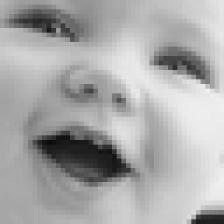

In [36]:
image

In [37]:
from transformers import pipeline

classifier = pipeline("image-classification", model="emotions_classif_model")
classifier(image)

Device set to use cpu


[{'label': 'neutral', 'score': 0.3762994706630707},
 {'label': 'sad', 'score': 0.35224950313568115},
 {'label': 'happy', 'score': 0.2714509963989258}]

OR

In [ ]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("emotions_classif_model")
inputs = image_processor(image, return_tensors="pt")

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_awesome_food_model")
with torch.no_grad():
    logits = model(**inputs).logits